In [1]:
#components of a time serie trend seasonality cyclicity irregularity
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['axes.grid']      = True
plt.rcParams['font.size']      = 12

In [3]:
df = pd.read_excel('../time_series_onamet_data.xlsx')

sttn, field = ['LC', 'TMAX']

if sttn == 'LA':
    sttn = 'Las Americas'
    s    = 'LA'
else: 
    sttn = 'La Central'
    s    = 'LC'
col_name = f'{field}_{s}'   

df = df[["DATE", col_name]]
df.set_index('DATE', inplace=True)
#https://itecnote.com/tecnote/python-arima-model-missingdataerror-exog-contains-inf-or-nans/
df = df.fillna(method='ffill')

In [4]:
def test_stationarity(df, sttn, s, field, col_name, DFT = True):
    #rolling statistics
    window = 365
    rolmean  = df.rolling(window = window).mean()
    rolmean2 = rolmean.rolling(window = window).mean().rolling(window = window).mean()
    # rolmean = rolmean.rolling(window = 365).mean()
    rolstd = df.rolling(window = window).std()#.rolling(window = window).std()
    
    dfplot = plt.plot(df, color='b', label=f'{field} (C)')
    mean  = plt.plot(rolmean, color='r', label='Rolling Mean')
    mean2 = plt.plot(rolmean2, color='k', label='R-Rolling Mean')
    std  = plt.plot(rolstd, color='y', label='Rolling STD')
    plt.legend(loc='best')
    plt.title(f'{sttn} {field} (C) Time Serie (1960-2021) - Rolling Statistics (Mean & STD)')
    plt.gcf()
    plt.savefig(f'../rolling_{field}_{s}', bbox_inches='tight')
    plt.show(block=False)
        
    if DFT:
        print('Results of Dickey Fuller Test')
        dftest = adfuller(df[col_name], autolag='AIC')

        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p vaue', 
                                        '# Lags Used', '# of Obs Used'])
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)        

<AxesSubplot:xlabel='DATE'>

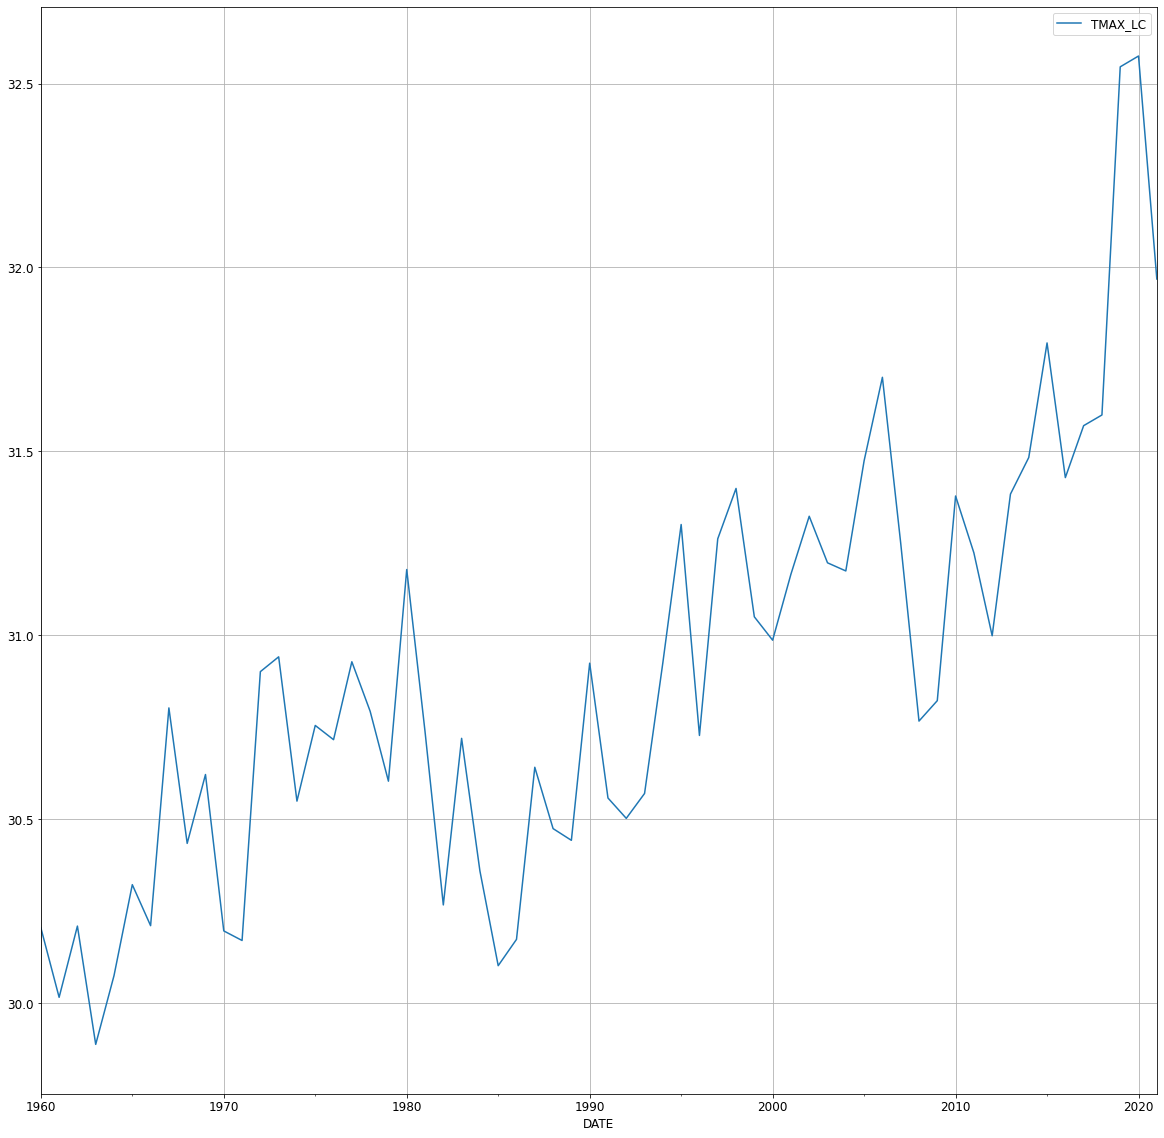

In [20]:
df_resam = df[[col_name]].resample("A").mean()
df_resam.plot()

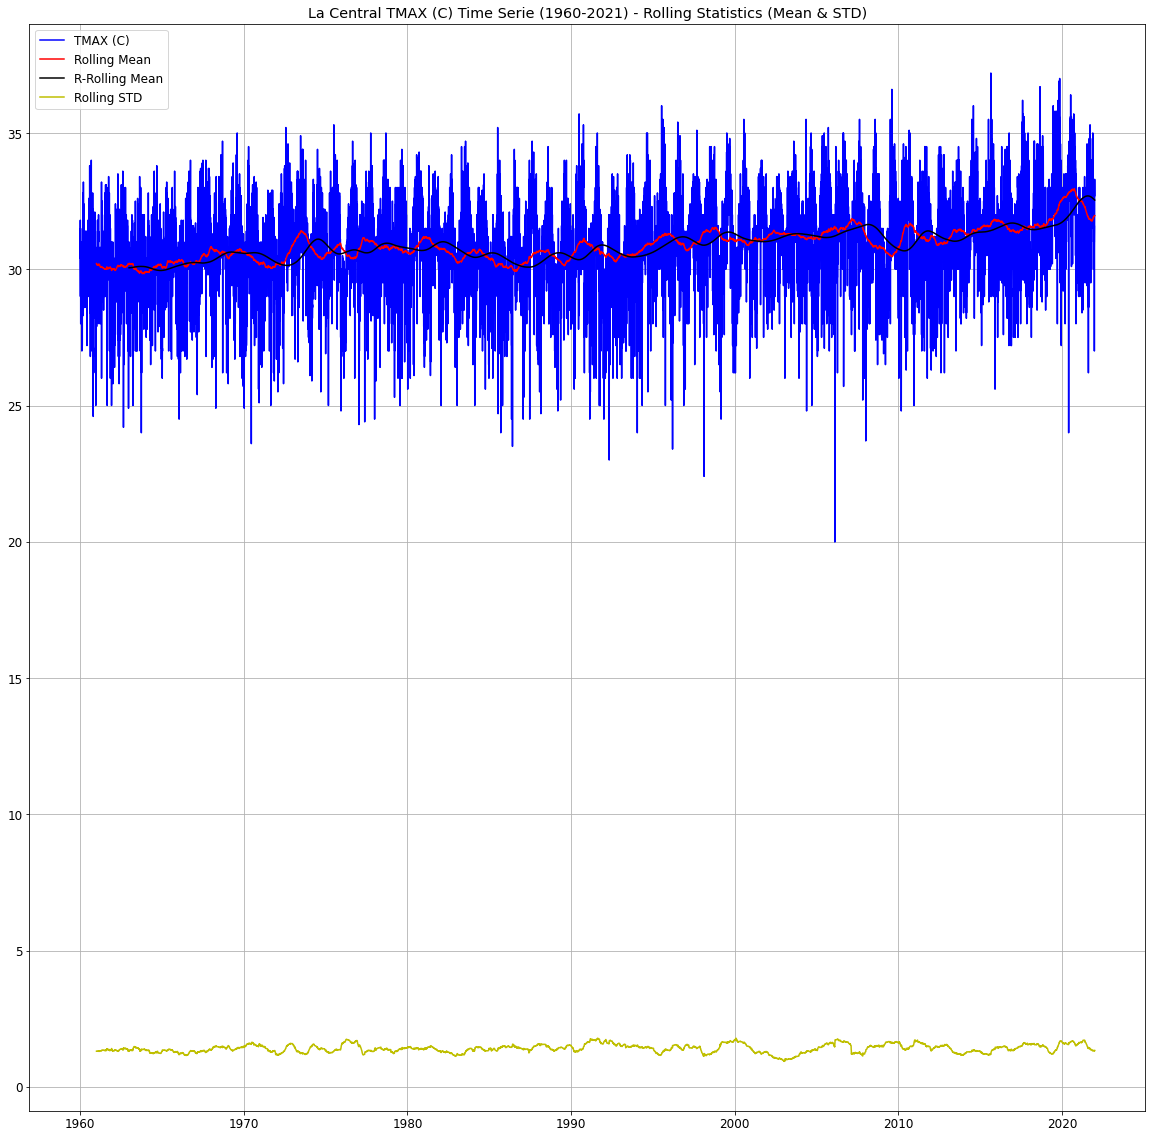

Results of Dickey Fuller Test
Test Statistic         -1.036278e+01
p vaue                  2.372633e-18
# Lags Used             2.800000e+01
# of Obs Used           2.261700e+04
Critical Value (1%)    -3.430639e+00
Critical Value (5%)    -2.861668e+00
Critical Value (10%)   -2.566838e+00
dtype: float64


In [17]:
test_stationarity(df=df, sttn=sttn, s=s, field=field, col_name=col_name)

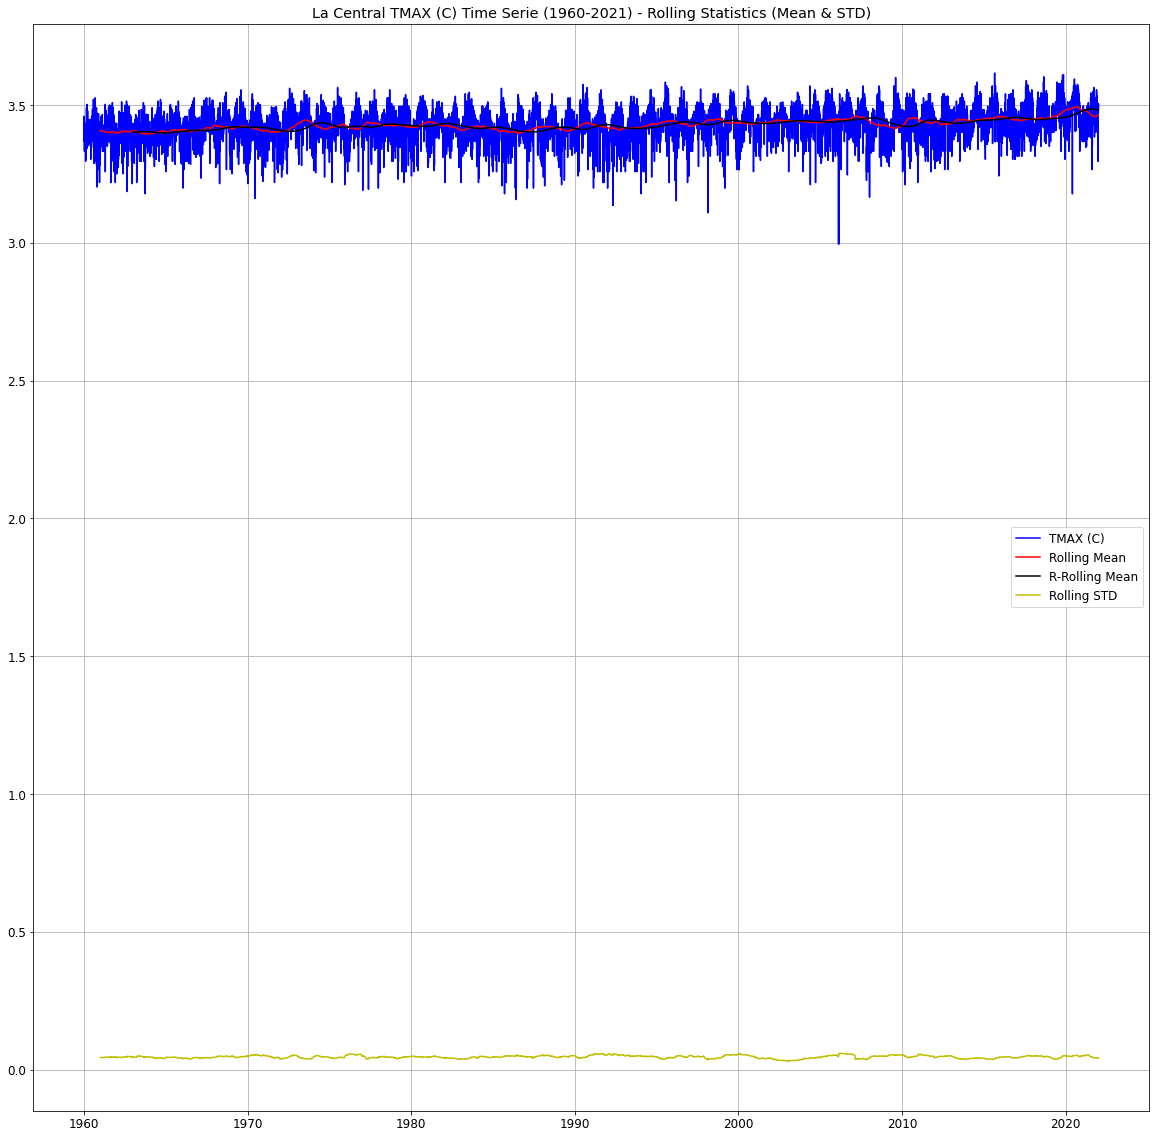

Results of Dickey Fuller Test
Test Statistic         -1.049062e+01
p vaue                  1.149550e-18
# Lags Used             2.800000e+01
# of Obs Used           2.261700e+04
Critical Value (1%)    -3.430639e+00
Critical Value (5%)    -2.861668e+00
Critical Value (10%)   -2.566838e+00
dtype: float64


In [7]:
df_logScale = np.log(df)
# plt.plot(df_logScale)
# plt.show()
test_stationarity(df=df_logScale, sttn=sttn, s=s, field=field, col_name=col_name)

In [8]:
movingAverage = df_logScale.rolling(window=250).mean()
logMinusMovingAvrg = df_logScale - movingAverage

logMinusMovingAvrg.dropna(inplace=True)
logMinusMovingAvrg

,TMAX_LC
DATE,
1960-09-06,0.017156
1960-09-07,-0.002386
1960-09-08,0.007486
1960-09-09,-0.002295
1960-09-10,0.030358
...,...
2021-12-27,-0.011341
2021-12-28,-0.026952
2021-12-29,-0.011305


test_stationarity(df=logMinusMovingAvrg, sttn=sttn, s=s, 
                  field=field, col_name=col_name)

3-Differecing Exponential Moving Average

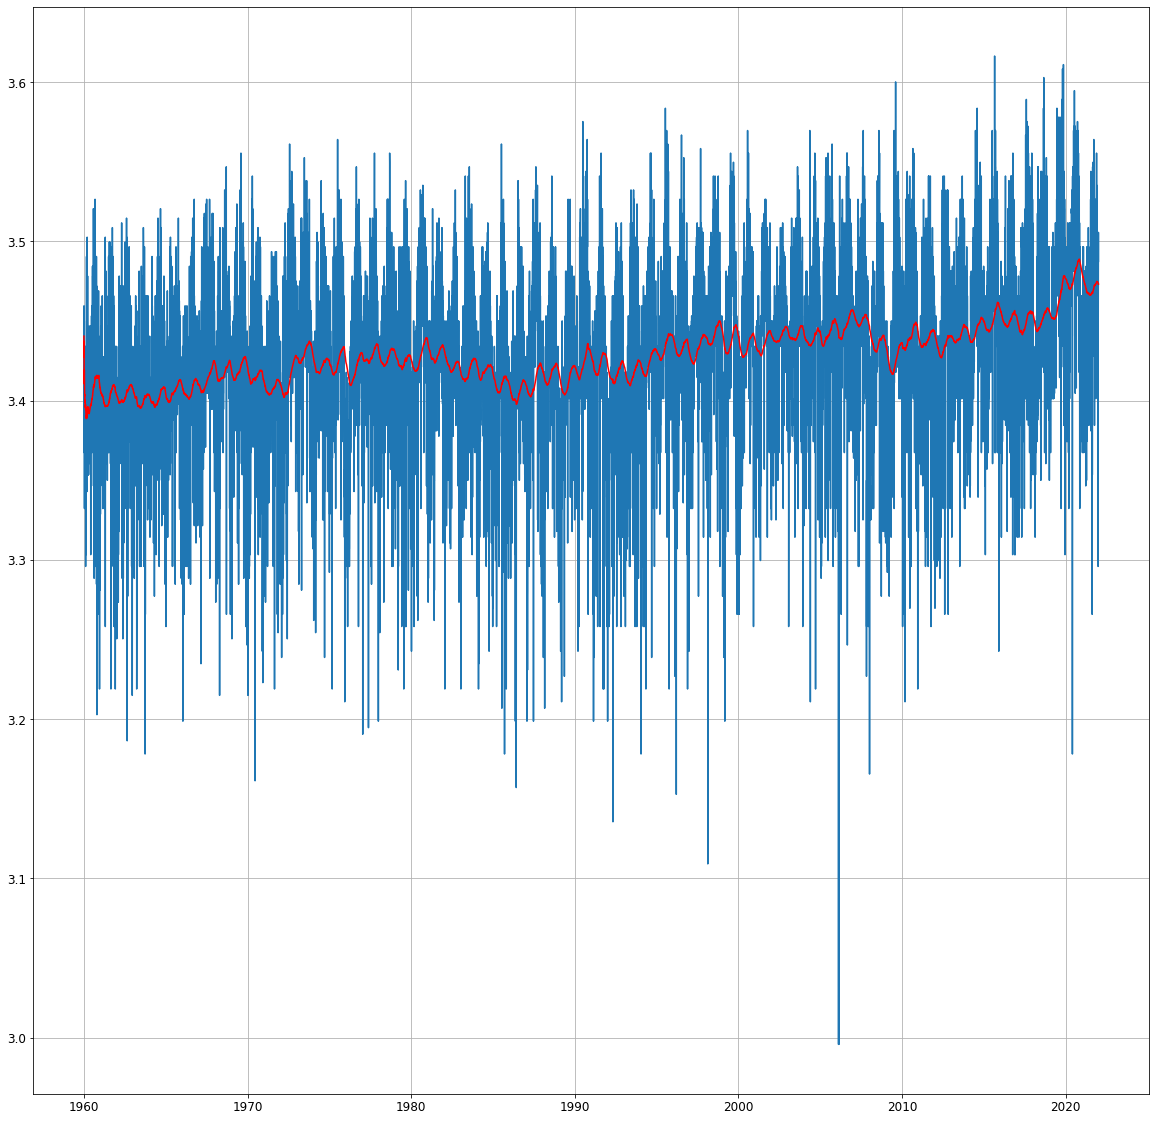

In [9]:
expDecayWeightedAvrg = df_logScale.ewm(halflife=250, min_periods=0,
                                       adjust=True).mean()
plt.plot(df_logScale)
plt.plot(expDecayWeightedAvrg, color='r')
plt.show()

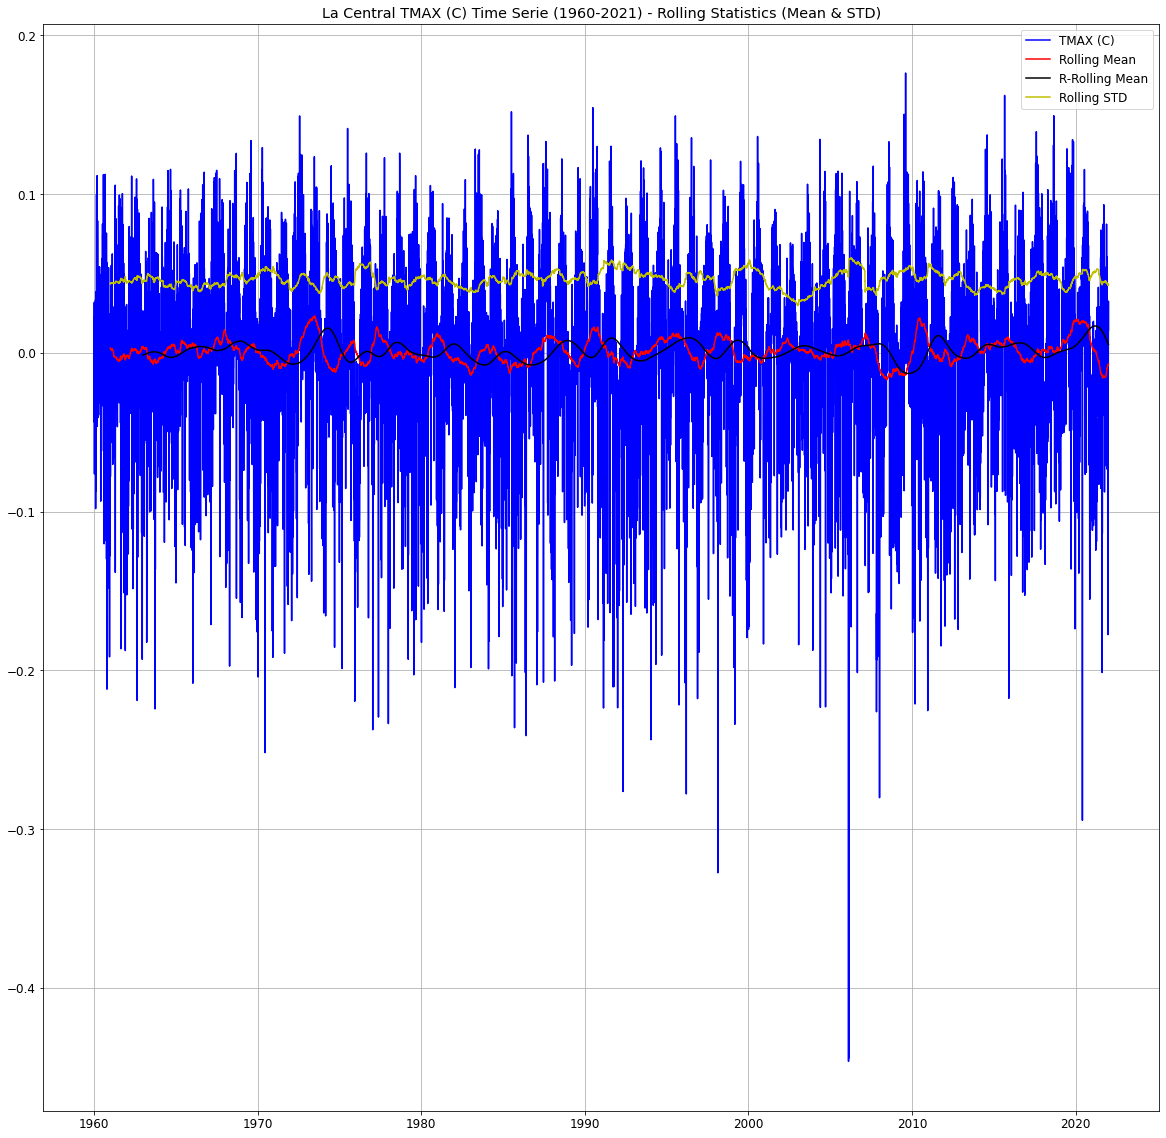

Results of Dickey Fuller Test
Test Statistic         -1.244420e+01
p vaue                  3.695699e-23
# Lags Used             2.600000e+01
# of Obs Used           2.261900e+04
Critical Value (1%)    -3.430639e+00
Critical Value (5%)    -2.861668e+00
Critical Value (10%)   -2.566838e+00
dtype: float64


In [10]:
logScaleMinusEDWA = df_logScale - expDecayWeightedAvrg
test_stationarity(df=logScaleMinusEDWA, sttn=sttn, s=s, 
                  field=field, col_name=col_name)

4-Diffrencing Previous Value

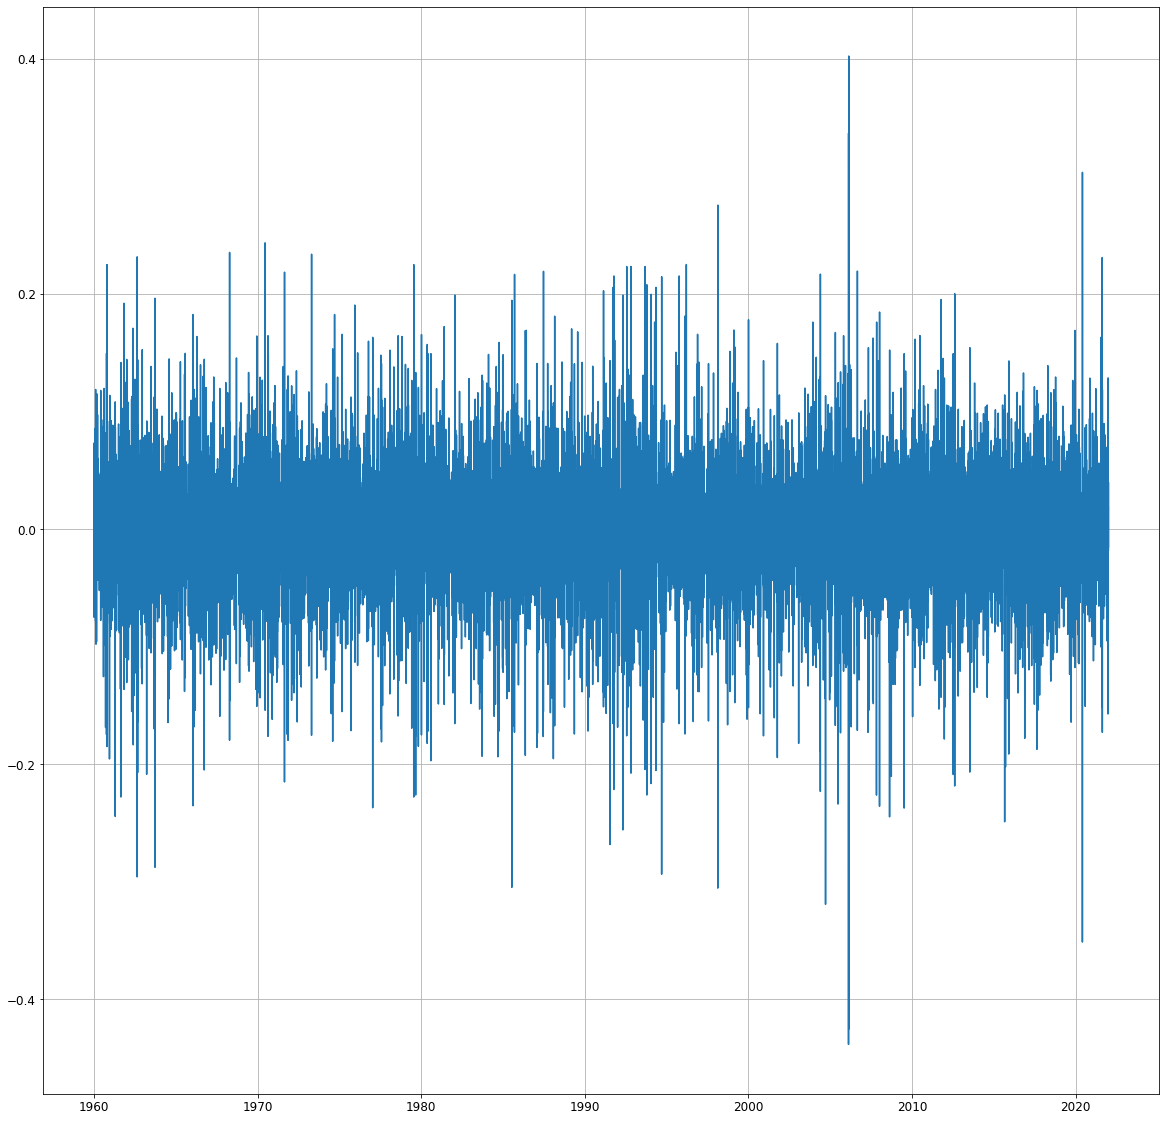

In [11]:
LogDiffShifting = df_logScale - df_logScale.shift()
plt.plot(LogDiffShifting)
plt.show()

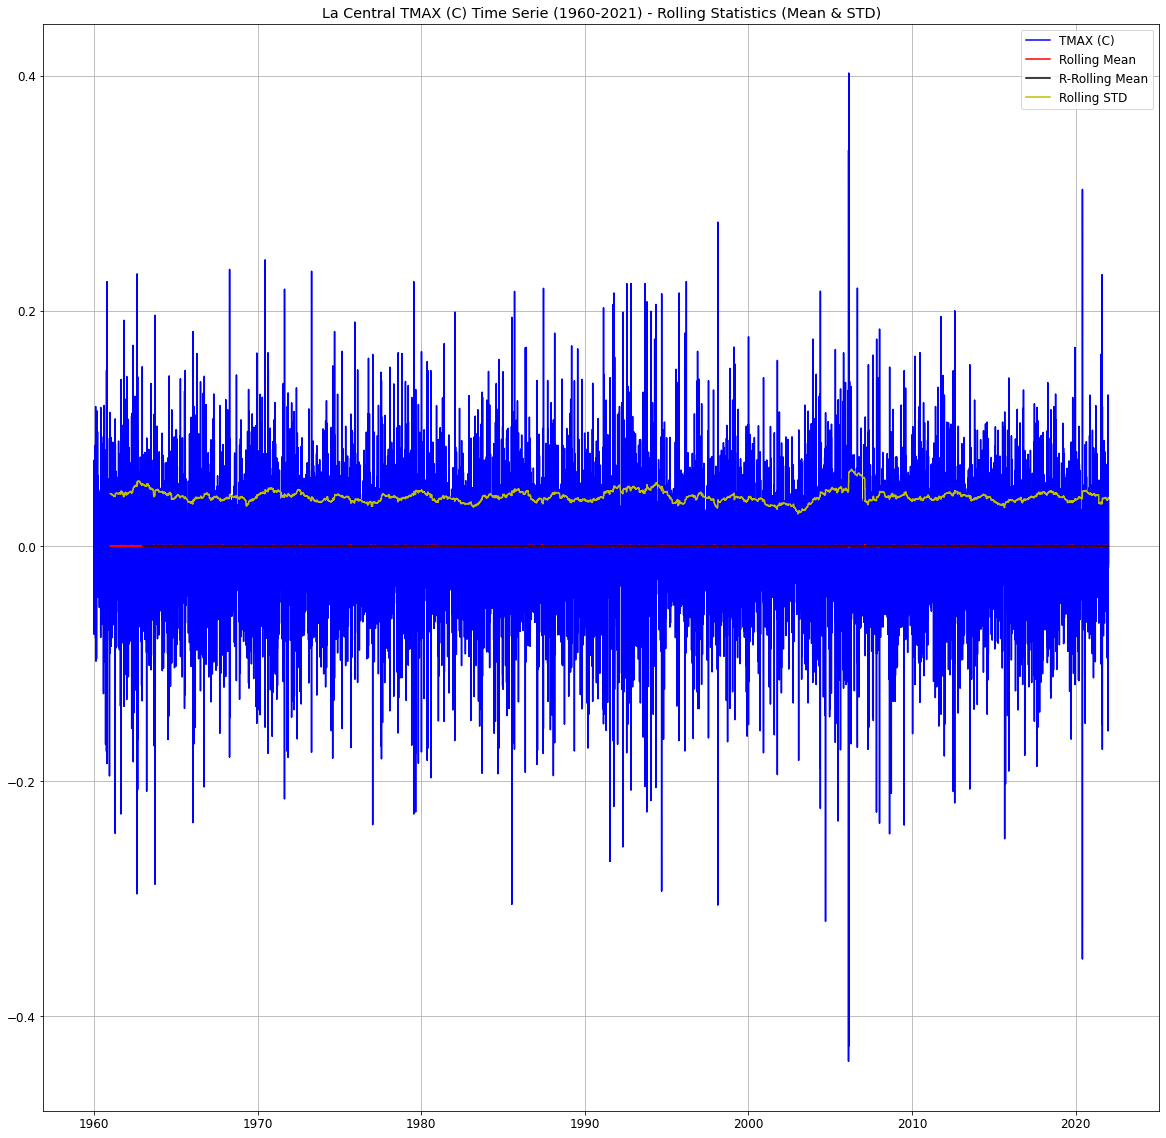

Results of Dickey Fuller Test
Test Statistic            -36.064598
p vaue                      0.000000
# Lags Used                33.000000
# of Obs Used           22611.000000
Critical Value (1%)        -3.430639
Critical Value (5%)        -2.861668
Critical Value (10%)       -2.566838
dtype: float64


In [12]:
LogDiffShifting.dropna(inplace=True)
test_stationarity(df=LogDiffShifting, sttn=sttn, s=s, 
                  field=field, col_name=col_name)

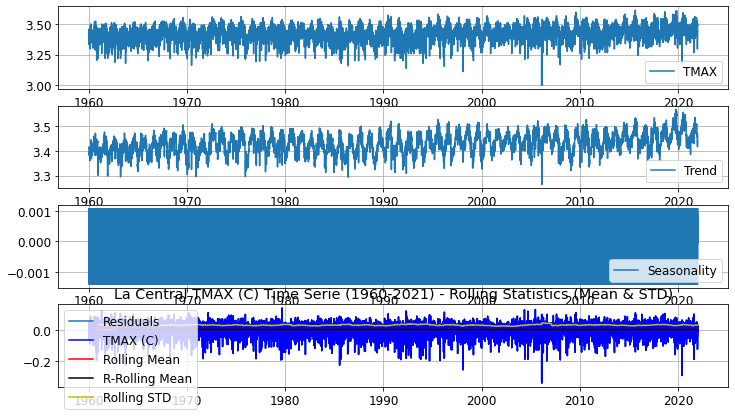

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_logScale)

trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,7))

plt.subplot(411)
plt.plot(df_logScale, label=field)
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

residual.dropna(inplace=True)
test_stationarity(df=residual, sttn=sttn, s=s, 
                  field=field, col_name=col_name, DFT=False)